In [22]:
import sys
import os
import pickle
from scipy import sparse
import scanpy as sc
import anndata as ad
from anndata import AnnData
import scvi
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
import torch.nn as nn

from perturbnet.util import * 
from perturbnet.cinn.flow import * 
from perturbnet.chemicalvae.chemicalVAE import *
from perturbnet.data_vae.vae import *
from perturbnet.cinn.flow_generate import TFVAEZ_CheckNet2Net
from tqdm import tqdm
import pickle5
from perturbnet.baselines.knn import *
from sklearn.neighbors import NearestNeighbors


%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Preparation

In [5]:
some_path = ""

path_cinn_model = some_path + 'cinn_iso_clean/100ep/100ep/'
path_data = ""
path_chemvae_model = some_path + "/chemicalvae/zinc/model_params_525.pt"


path_vae_model_train = some_path + '/cellvae/150ep/model/'
path_chem_onehot = some_path + "/zinc/"

adata = ad.read_h5ad(os.path.join(path_data, "lincs_corrected_isoforms_splits.h5ad"))
with open(some_path + "/LINCS-Drugs/rank_genes_group.pkl", "rb") as fh:
    degs = pickle5.load(fh)
adata.uns["rank_genes_groups"] = degs
    
adata_save_index = np.array(adata.obs[adata.obs["perturb_string_chemvae_flag"] == 1].index).astype(int)
adata = adata[adata_save_index, :].copy()    
print(adata.obs.shape)
adata.obs = adata.obs.reset_index()
    
adata_save_index = np.array(adata.obs[adata.obs["chem_iso_saved_flag"] != "iso_removed"].index).astype(int)
adata = adata[adata_save_index, :].copy()    
print(adata.obs.shape)
adata.obs = adata.obs.reset_index(drop = True)
    
adata_test_index = np.array(adata.obs[adata.obs["holdout1"] == "test"].index).astype(int)
adata_test = adata[adata_test_index, :].copy()
    
adata_train_index = np.array(adata.obs[adata.obs["holdout1"] == "train"].index).astype(int)
adata_train = adata[adata_train_index, :].copy()
data_chem_onehot = np.load(os.path.join(path_chem_onehot, "onehot_zinc.npy"))
usedata = adata_test.X
alldata = adata.X

perturb_with_onehot_kept, perturb_with_onehot_removed = np.array(adata_train.obs["perturb_string"]), np.array(adata_test.obs["perturb_string"])
trt_obs_list, trt_unseen_list = np.unique(perturb_with_onehot_kept), np.unique(perturb_with_onehot_removed)    
onehot_unseen_idx = []
for i in range(len(trt_unseen_list)):
    trt = trt_unseen_list[i]
    onehot_idx = np.where(adata.uns["ordered_all_smile"] == trt)[0][0]
    onehot_unseen_idx.append(onehot_idx)
    unseen_onehot = adata.uns["ordered_all_onehot"][onehot_unseen_idx]

onehot_seen_idx = []
for i in range(len(trt_obs_list)):
    trt = trt_obs_list[i]
    onehot_idx = np.where(adata.uns["ordered_all_smile"] == trt)[0][0]
    onehot_seen_idx.append(onehot_idx)
seen_onehot = adata.uns["ordered_all_onehot"][onehot_seen_idx]    
    





#Zsample = vae_train.encode(usedata)


(674279, 28)


/home/wzqian/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


(527626, 29)


# PerturbNet

In [ ]:
vae_train = VAE(num_cells_train = usedata.shape[0], x_dimension = usedata.shape[1], learning_rate = 1e-4, BNTrainingMode = False)
vae_train.restore_model(tf.train.latest_checkpoint(path_vae_model_train))

# (2) load models
device = "cuda" if torch.cuda.is_available() else "cpu"

model_chemvae = ChemicalVAE(n_char = data_chem_onehot.shape[2],max_len = data_chem_onehot.shape[1]).to(device)
model_chemvae.load_state_dict(torch.load(path_chemvae_model, map_location = device))
model_chemvae.eval()


std_model = Standardize(data_all = data_chem_onehot, model = model_chemvae, device = device)



perturbToOnehot = {}
for i in range(trt_unseen_list.shape[0]):
    perturbToOnehot[trt_unseen_list[i]] = i    
        
        
torch.manual_seed(42)
flow_model = ConditionalFlatCouplingFlow(conditioning_dim = 196,embedding_dim = 10, conditioning_depth = 2, n_flows = 20, 
                               in_channels = 10, hidden_dim = 1024, hidden_depth = 2, activation = "none", conditioner_use_bn = True)

model_c = Net2NetFlow_TFVAEFlow(configured_flow = flow_model, first_stage_data = usedata, cond_stage_data = perturb_with_onehot_removed,
                          perturbToOnehotLib = perturbToOnehot, oneHotData = unseen_onehot, model_con = model_chemvae, 
                          std_model = std_model,sess = vae_train.sess, enc_ph = vae_train.x, z_gen_data_v = vae_train.z_mean,
                          is_training = vae_train.is_training)

model_c.to(device = device)

model_c.load(path_cinn_model)
model_c.eval()

model_g = model_c.model_con
model_g.eval()

perturbnet_model = TFVAEZ_CheckNet2Net(model_c, device, vae_train.sess, vae_train.x_hat, vae_train.z_mean, vae_train.is_training)

In [11]:
fidscore_cal = fidscore()
adata.var["gene_idx"] = np.arange(0,adata.var.shape[0],1)
perturb = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []
pear = []
pear_deg = []
pear_large = []
np.random.seed(2023)

    
    
for indice_trt in range(len(trt_unseen_list)):

    trt_type = trt_unseen_list[indice_trt]
    pert = trt_type
    
    idx_trt_type = np.where(perturb_with_onehot_removed == trt_type)[0]

    if idx_trt_type.shape[0] > 1000:
        idx_trt_type = np.random.choice(idx_trt_type, 1000, replace = False)
    # make eval consistent with chemcpa
    elif idx_trt_type.shape[0] <= 5:
        continue  
    if pert == "CS(=O)C":
        continue

    #onehot_indice_trt = np.tile(unseen_onehot[[indice_trt]], (len(idx_trt_type), 1, 1))
    onehot_indice_trt = np.tile(unseen_onehot[[indice_trt]], (500, 1, 1))
    _, _, _, embdata_torch = model_g(torch.tensor(onehot_indice_trt).float().to(device))
    embdata_np = std_model.standardize_z(embdata_torch.cpu().detach().numpy())
        
    DEG_gene = adata.uns["rank_genes_groups"]["names"][trt_type]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])

    real_data = usedata[idx_trt_type]
    _, fake_data = perturbnet_model.sample_data(embdata_np)
        
    ## evaluation
    r2_value = fidscore_cal.calculate_r_square(real_data, fake_data)
    pear_value = fidscore_cal.calculate_pearson(real_data, fake_data)

        
    real_data_deg = real_data[:,DEG_idx]
    fake_data_deg = fake_data[:,DEG_idx]


    r2_deg_value = fidscore_cal.calculate_r_square(real_data_deg, fake_data_deg)
    pear_deg_value =  fidscore_cal.calculate_pearson(real_data_deg, fake_data_deg)
    
    large_effect_idx =  DEG_idx[abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1]

    num_large =  sum(abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1)
        
    if num_large <=1:
        r2_large_value=1.5
        pear_large_value=1.5
    else:
        real_data_large = real_data[:,large_effect_idx ]
        fake_data_large = fake_data[:,large_effect_idx ]
        r2_large_value = fidscore_cal.calculate_r_square(real_data_large, fake_data_large)
        pear_large_value = fidscore_cal.calculate_pearson(real_data_large , fake_data_large)
        

    perturb.append(pert)
    ncell.append(len(idx_trt_type))
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)
    pear.append(pear_value)
    pear_deg.append(pear_deg_value)
    pear_large.append(pear_large_value)


results_PerturbNet = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,
                        "r2":r2,
                        "r2_deg":r2_deg,
                        "r2_large":r2_large,
                         "pear":pear,
                        "pear_deg":pear_deg,
                        "pear_large":pear_large
                       })
    

In [24]:
results_PerturbNet.shape

(1889, 9)

# ChemCPA

In [14]:
data_path = some_path + "pred_dict_iso_clean.pkl"
with open(data_path, "rb") as fh:
    pred_dict = pickle5.load(fh)
    
    
perturb = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []
pear = []
pear_deg = []
pear_large = []
np.random.seed(2023)


for pert, pred  in tqdm(pred_dict.items()):
    

    fake_data = pred[0]
    real_data = pred[1]
    real_data = real_data.detach().numpy()
    fake_data = fake_data.detach().numpy()

    if real_data.shape[0] > 1000:
        real_data = real_data[np.random.choice(real_data.shape[0], 1000, replace = False)]
    elif real_data.shape[0] <= 5:
        continue


    DEG_gene = adata.uns["rank_genes_groups"]["names"][pert]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])
    
    
    r2_value = fidscore_cal.calculate_r_square(real_data, fake_data)
    pear_value = fidscore_cal.calculate_pearson(real_data, fake_data)


        
    ## Extra evaluation on DEG rsquare
    real_data_deg = real_data[:,DEG_idx]
    fake_data_deg = fake_data[:,DEG_idx]


    r2_deg_value = fidscore_cal.calculate_r_square(real_data_deg, fake_data_deg)
    pear_deg_value =  fidscore_cal.calculate_pearson(real_data_deg, fake_data_deg)

    
    large_effect_idx =  DEG_idx[abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1]

    num_large =  sum(abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1)


    if num_large <=1:
        r2_large_value=1.5
        pear_large_value=1.5
    else:
        real_data_large = real_data[:,large_effect_idx ]
        fake_data_large = fake_data[:,large_effect_idx ]
        r2_large_value = fidscore_cal.calculate_r_square(real_data_large, fake_data_large)
        pear_large_value =  fidscore_cal.calculate_pearson(real_data_large, fake_data_large)

    perturb.append(pert)
    ncell.append(real_data.shape[0])
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)
    pear.append(pear_value)
    pear_deg.append(pear_deg_value)
    pear_large.append(pear_large_value)
results_chemCPA = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,
                        "r2":r2,
                        "r2_deg":r2_deg,
                        "r2_large":r2_large,
                         "pear":pear,
                        "pear_deg":pear_deg,
                        "pear_large":pear_large
                       })

100%|██████████| 1888/1888 [00:04<00:00, 423.08it/s]


# Training Sample

In [30]:
adata.var["gene_idx"] = np.arange(0,adata.var.shape[0],1)
perturb = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []
pear = []
pear_deg = []
pear_large = []
np.random.seed(2023)
count = 0
    
for indice_trt in range(len(trt_unseen_list)):

    trt_type = trt_unseen_list[indice_trt]
    pert = trt_type
    
    seen_data = adata_train.X
    seen_data_idx = list(range(seen_data.shape[0]))
    idx_trt_type = np.where(perturb_with_onehot_removed == trt_type)[0]
    if idx_trt_type.shape[0] > 1000:
        idx_trt_type = np.random.choice(idx_trt_type, 1000, replace = False)
    # make eval consistent with chemcpa
    elif idx_trt_type.shape[0] <= 5:
        continue  
    
    if pert == "CS(=O)C":
        continue
        
    DEG_gene = adata.uns["rank_genes_groups"]["names"][trt_type]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])

    real_data = usedata[idx_trt_type]
    
    idx_rsample = np.random.choice(seen_data_idx, len(idx_trt_type), replace=True)
    fake_data = seen_data[idx_rsample]

        ## evaluation
    r2_value = fidscore_cal.calculate_r_square(real_data, fake_data)
    pear_value = fidscore_cal.calculate_pearson(real_data, fake_data)


        
    ## Extra evaluation on DEG rsquare
    real_data_deg = real_data[:,DEG_idx]
    fake_data_deg = fake_data[:,DEG_idx]


    r2_deg_value = fidscore_cal.calculate_r_square(real_data_deg, fake_data_deg)
    pear_deg_value = fidscore_cal.calculate_pearson(real_data_deg, fake_data_deg)
    
    large_effect_idx =  DEG_idx[abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1]

    num_large =  sum(abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1)
    if num_large <=1:
        hd_large_value=1.5
        r2_large_value=1.5
        pear_large_value=1.5
    else:
        real_data_large = real_data[:,large_effect_idx ]
        fake_data_large = fake_data[:,large_effect_idx ]
        r2_large_value = fidscore_cal.calculate_r_square(real_data_large, fake_data_large)
        pear_large_value =  fidscore_cal.calculate_pearson(real_data_large , fake_data_large)
        
    perturb.append(pert)
    ncell.append(len(idx_trt_type))
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)

    pear.append(pear_value)
    pear_deg.append(pear_deg_value)
    pear_large.append(pear_large_value)
    
results_sample = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,
                        "r2":r2,
                        "r2_deg":r2_deg,
                        "r2_large":r2_large,
                         "pear":pear,
                        "pear_deg":pear_deg,
                        "pear_large":pear_large})

# KNN

In [23]:
_, _, _, embdata_torch_seen = model_chemvae(torch.tensor(seen_onehot).float().to(device))
embdata_numpy_seen = std_model.standardize_z(embdata_torch_seen.cpu().detach().numpy())
_, _, _, embdata_torch_unseen = model_chemvae(torch.tensor(unseen_onehot).float().to(device))
embdata_numpy_unseen = std_model.standardize_z(embdata_torch_unseen.cpu().detach().numpy())

neigh = NearestNeighbors(n_neighbors=5)
neigh_fit = neigh.fit(embdata_numpy_seen)

adata.var["gene_idx"] = np.arange(0,adata.var.shape[0],1)
perturb = []
ncell = []
n_large = []
r2 = []
r2_deg = []
r2_large = []
pear = []
pear_deg = []
pear_large = []
np.random.seed(2023)
seen_data = adata_train.X
seen_data_idx = list(range(seen_data.shape[0]))    

for indice_trt in tqdm(range(len(trt_unseen_list))):

    trt_type = trt_unseen_list[indice_trt]
    pert = trt_type
    

    idx_trt_type = np.where(perturb_with_onehot_removed == trt_type)[0]
    if idx_trt_type.shape[0] > 1000:
        idx_trt_type = np.random.choice(idx_trt_type, 1000, replace = False)
    # make eval consistent with chemcpa
    elif idx_trt_type.shape[0] <= 5:
        continue  
    
    if pert == "CS(=O)C":
        continue
        
    DEG_gene = adata.uns["rank_genes_groups"]["names"][trt_type]
    DEG_idx = np.array(adata.var.loc[DEG_gene]["gene_idx"])

    real_data = usedata[idx_trt_type]
    
    distances, other_trts = neigh_fit.kneighbors(embdata_numpy_unseen[[indice_trt]], 5, return_distance=True)
    samplerNN = samplefromNeighbors(distances, other_trts)
    idx_sample = samplerNN.samplingTrt(trt_obs_list, perturb_with_onehot_kept, len(idx_trt_type))
    
    #idx_rsample = np.random.choice(seen_data_idx, len(idx_trt_type), replace=True)
    fake_data = seen_data[idx_sample]

        ## evaluation
    r2_value = fidscore_cal.calculate_r_square(real_data, fake_data)
    pear_value = fidscore_cal.calculate_pearson(real_data, fake_data)

    
    ## Extra evaluation on DEG rsquare
    real_data_deg = real_data[:,DEG_idx]
    fake_data_deg = fake_data[:,DEG_idx]


    r2_deg_value = fidscore_cal.calculate_r_square(real_data_deg, fake_data_deg)
    pear_deg_value = fidscore_cal.calculate_pearson(real_data_deg, fake_data_deg)
    
    large_effect_idx =  DEG_idx[abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1]

    num_large =  sum(abs(adata.uns["rank_genes_groups"]["logfoldchanges"][pert])>=1)
    if num_large <=1:
        hd_large_value=1.5
        r2_large_value=1.5
        pear_large_value=1.5
    else:
        real_data_large = real_data[:,large_effect_idx ]
        fake_data_large = fake_data[:,large_effect_idx ]
        r2_large_value = fidscore_cal.calculate_r_square(real_data_large, fake_data_large)
        pear_large_value =  fidscore_cal.calculate_pearson(real_data_large , fake_data_large)
        
    perturb.append(pert)
    ncell.append(len(idx_trt_type))
    n_large.append(num_large)
    r2.append(r2_value)
    r2_deg.append(r2_deg_value)
    r2_large.append(r2_large_value)

    pear.append(pear_value)
    pear_deg.append(pear_deg_value)
    pear_large.append(pear_large_value)
    
results_KNN = pd.DataFrame({"perturbation":perturb, "number_real_cells_used":ncell,"n_large":n_large,
                        "r2":r2,
                        "r2_deg":r2_deg,
                        "r2_large":r2_large,
                         "pear":pear,
                        "pear_deg":pear_deg,
                        "pear_large":pear_large})


100%|██████████| 1988/1988 [02:37<00:00, 12.60it/s]


../perturbnet/util.py:928: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


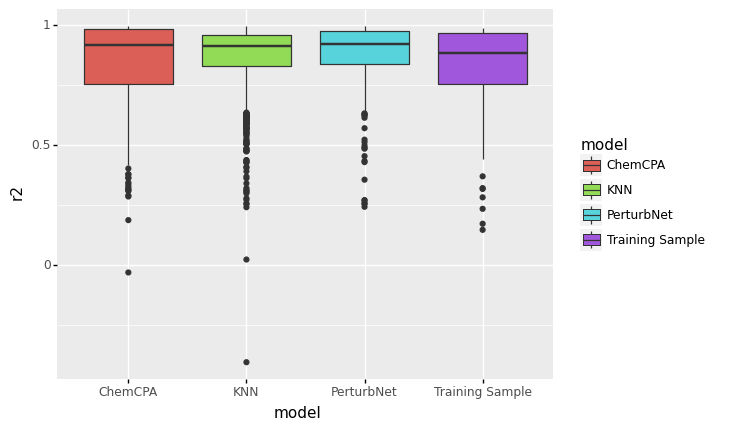

<ggplot: (1418099123645)>

In [31]:
boxplot_metrics({"PerturbNet":results_PerturbNet, "ChemCPA":results_chemCPA, "Training Sample":results_sample,
                "KNN": results_KNN }, metric_key = "r2")

../perturbnet/util.py:928: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


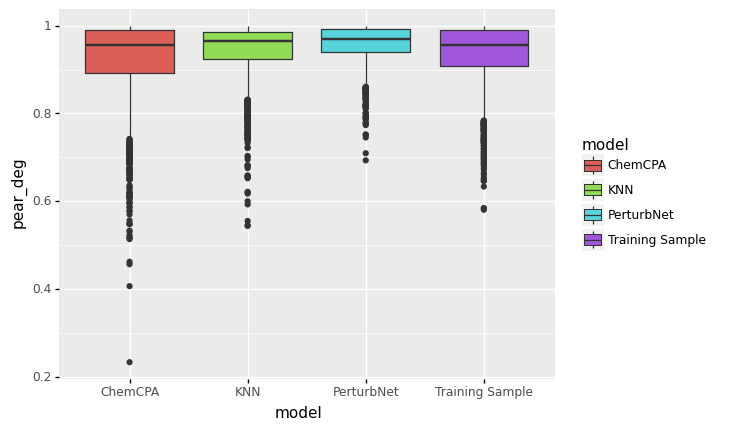

<ggplot: (1418099548677)>

In [32]:
boxplot_metrics({"PerturbNet":results_PerturbNet, "ChemCPA":results_chemCPA, "Training Sample":results_sample,
                "KNN": results_KNN }, metric_key = "pear_deg")